# Positive-unlabeled learning


We consider the problem of learning a binary classifier only from positive data and unlabeled data (PU learning)

ositive-unlabeled learning is an important subparadigm of semi-supervised learning, where the only labeled data points available are positive. For example, suppose we only know about Justine’s favorite novels. (Why would she talk about the ones she didn’t enjoy, anyway?)

The standard supervised machine learning paradigm would be out of luck in this situation, because any standard model’s algorithm requires both positive and negative examples to train. But again, despite their ambiguity, unlabeled data points can be helpful here if we’re clever about how to use them.

Consider the following new caricature. We have a few positive data points (illustrated in green below), but no negatives. We must divide the feature plane into two regions, where points are predicted to be positive in one region and negative in the other. Our decision about how to do this will be very different indeed if we know where unlabeled data points lie!

<img src="images/pu_1.PNG"> </img>
<img src="images/pu_2.PNG"> </img>
<img src="images/pu_3.PNG"> </img>



## Some techniques for PU learning

There has been a great deal of interest in developing approaches to PU learning problems. Since standard machine learning problems (in which a large number of positive and negative data points can be used to train a model) are a well-explored field with many solution methods, most approaches to PU learning involve clever adaptations of standard methods.

Following is a quick summary of a few techniques, most of which will be applied experimentally later.

### 1. Direct application of a standard classifier


Perhaps the most obvious approach to a PU problem is as follows: treat the positive and unlabeled data points as positives and negatives, respectively. Train a standard classifier model on the data. The classifier will assign a score to each data point, with positives generally scored higher than negatives. Among the unlabeled data points (temporarily labeled as negatives), the ones with the highest scores should be most likely to be positives.

This naïvest of approaches is explored and somewhat justified in <a id='https://sites.tntech.edu/weberle/'>Learning classifiers from only positive and unlabeled data (2008)</a> by Elkan and Noto. The central result of that paper is that, under certain assumptions that are basic but probably slightly unreasonable for real-life purposes, a standard classifier trained on positive and unlabeled data should give scores that are proportional to the scores it would give if it were properly trained on positive and negative data.

As the authors note, “This means that if the [hypothetically properly trained] classifier is only used to rank examples according to the chance that they belong to [the positives], then the classifier [trained on positive and unlabeled data] can be used directly instead.”

### 2. PU bagging

A related but more sophisticated approach to a given PU problem involves a variation on bagging:

1. Create a training set by combining all positive data points with a random sample from the unlabeled points, with replacement.

2. Build a classifier from this “bootstrap” sample, treating positive and unlabeled data points as positives and negatives, respectively.

3. Apply the classifier to whatever unlabeled data points were not included in the random sample – hereafter called OOB (“out of bag”) points – and record their scores.

4. Repeat the three steps above many times and finally assign to each point the average of the OOB scores it has received.


One paper describing this approach is <a id='http://members.cbio.mines-paristech.fr/~jvert/svn/bibli/local/Mordelet2013bagging.pdf'> A bagging SVM to learn from positive and unlabeled examples</a> (2013) by Mordelet and Vert. According to the authors, “the method can match and even outperform the performance of state-of-the-art methods for PU learning, particularly when the number of positive examples is limited and the fraction of negatives among the unlabeled examples is small. The proposed method can also run considerably faster than state-of-the-art methods, particularly when the set of unlabeled examples is large.”


### 3. Two-step approaches

A wide variety of PU learning strategies fall into the general category of  “two-step approaches.” One decent introduction to these is given in <a id='http://ijcat.com/archives/volume3/issue9/ijcatr03091012.pdf'> An Evaluation of Two-Step Techniques for Positive-Unlabeled Learning in Text Classification</a> (2014) by Kaboutari, Bagherzadeh, and Kheradmand.

Here are the “two steps” of this kind of approach:

1. Identify a subset of the unlabeled data points that can be confidently labeled as negatives. (The authors of the paper above call these points “reliable negatives.”)

2. Use the positive and negative data points to train a standard classifier and apply it to the remaining unlabeled points.

Typically, the results of the second step are used in order to return to the first step and iterate. As the authors above state, “If the [reliable negative] set contains mostly negative documents and is sufficiently large, a learning algorithm… works very well and will be able to build a good classifier. But often a very small set of negative documents identified in step 1… then a learning algorithm iteratively runs till it converges or some stopping criterion is met.”

A similar approach is laid out by Shubham Jain in the recent blog post <a id='https://www.analyticsvidhya.com/blog/2017/09/pseudo-labelling-semi-supervised-learning-technique/'>Introduction to Pseudo-Labelling : A Semi-Supervised learning technique</a>, but the details there are not specifically aimed at PU problems.

### 4. Positive unlabeled random forest

One last development worth mentioning here, although it will not be included in our experiments below, is an algorithm introduced in <a id='https://link.springer.com/chapter/10.1007/978-3-319-14717-8_45'>Towards Positive Unlabeled Learning for Parallel Data Mining: A Random Forest Framework</a> (2014) by Li and Hua.


According to the authors, “The proposed framework, termed PURF (Positive Unlabeled Random Forest), is able to learn from positive and unlabeled instances and achieve comparable classification performance with RF trained by fully labeled data through parallel computing according to experiments on both synthetic and real-world UCI datasets… This framework combines PU learning techniques including widely used PU information gain (PURF-IG) and newly developed PU Gini index (PURF-GI) with an extendable parallel computing algorithm (i.e. RF).”

Furthermore, the authors report that they have “implemented PURF with Python based on the scikit-learn package,” so if the code is made publically available at some point, it may be a promising tool.



## Implementation

"Blobs" data set


In [1]:

import pandas as pd                    # for data handling
import numpy as np                     # for random selections, mainly
import matplotlib.pyplot as plt        # for plotting
%matplotlib inline                  
plt.rcParams['figure.figsize'] = 7,7   # graph dimensions
plt.rcParams['font.size'] = 14         # graph font size

In [2]:
# Create the data set
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(
    n_samples = 6000, 
    centers = [[1,5], [5,1], [0,0], [6,6]]
)
y = (y > 1).astype(int)  # Convert the original labels [0,1,2,3] to [0,1]
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

In [4]:
# Check the contents of the set
print('%d data points and %d features' % (X.shape))
print('%d positive out of %d total' % (sum(y), len(y)))

6000 data points and 2 features
3000 positive out of 6000 total


In [5]:

# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 2700
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

In [6]:
# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

300 positive out of 6000 total


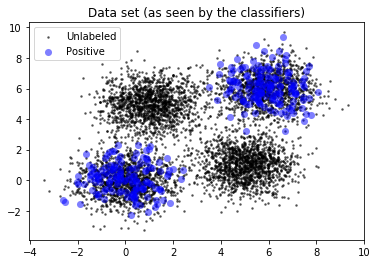

In [7]:
# Plot the data set, as the models will see it
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

## Standard classifier¶


In [8]:
# We'll use a generic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

C:\Users\ugur.ceylan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


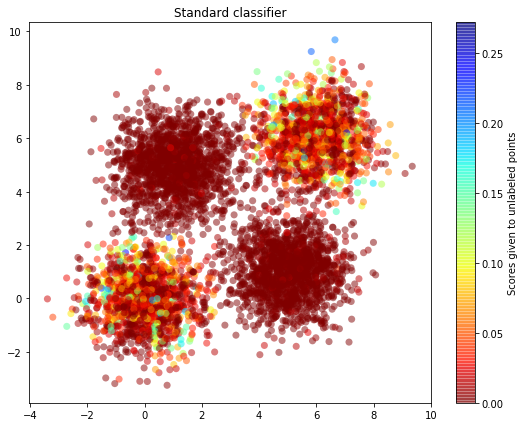

In [9]:

# Visualize this approach's results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

## Bagging

In [10]:
# Use 1000 trees
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000
estimator = DecisionTreeClassifier()

# Keep track of the indices of positive and unlabeled data points
iP = y[y > 0].index
iU = y[y <= 0].index

# For each data point, keep track of how many times it has been OOB...
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

# ...and the sum of its OOB scores
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

for _ in range(n_estimators):
    # Get a bootstrap sample of unlabeled points for this round
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # Find the OOB data points for this round
    i_oob = list(set(iU) - set(ib))

    # Get the training data (ALL positives and the bootstrap 
    # sample of unlabeled points) and build the tree
    Xb = X[y > 0].append(X.loc[ib])
    yb = y[y > 0].append(y.loc[ib])
    estimator.fit(Xb, yb)
    
    # Record the OOB scores from this round
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

# Finally, store the scores assigned by this approach
results['output_bag'] = sum_oob / num_oob

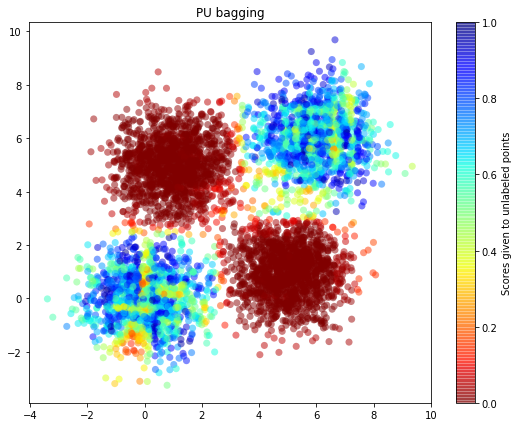

In [11]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU bagging')
plt.show()

## Using BaggingClassifierPU

In [13]:
from baggingPU import BaggingClassifierPU
bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)
results['output_skb'] = bc.oob_decision_function_[:,1]

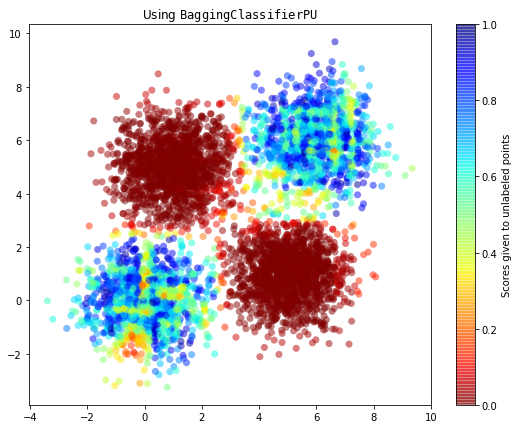

In [14]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_skb, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()

## Two-step

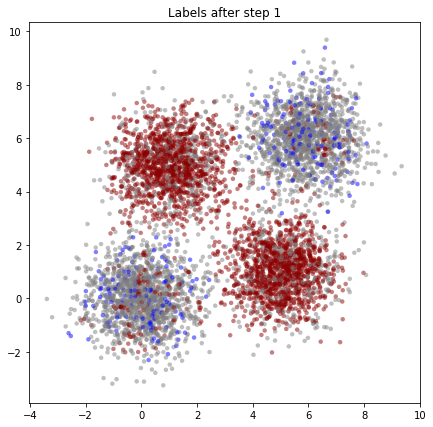

Step 1 labeled 0 new positives and 2504 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 488 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 108 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 67 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 33 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 27 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 27 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 21 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 15 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 12 new negatives.
Doing step 2... 

In [15]:
# Create a new target vector, with 1 for positive, -1 for unlabeled, and 
# 0 for "reliable negative" (there are no reliable negatives to start with)
ys = 2 * y - 1

# Get the scores from before
pred = rf.predict_proba(X)[:,1]

# Find the range of scores given to positive data points
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

# STEP 1
# If any unlabeled point has a score above all known positives, 
# or below all known positives, label it accordingly
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# Show the results of step 1
plt.rcParams['figure.figsize'] = 7,7
cdict = {-1:'gray', 0:'darkred', 1:'blue'}
plt.scatter(
    X.feature1, X.feature2, 
    c = [cdict[k] for k in ys], 
    linewidth = 0, s = 20, alpha = 0.5
)
plt.title('Labels after step 1')
plt.show()   

# Classifier to be used for step 2
rf2 = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)

# Limit to 10 iterations (this is arbitrary, but 
# otherwise this approach can take a very long time)
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get new scores
    rf2.fit(X, ys)
    pred = rf2.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# Lastly, get the scores assigned by this approach    
results['output_stp'] = pred

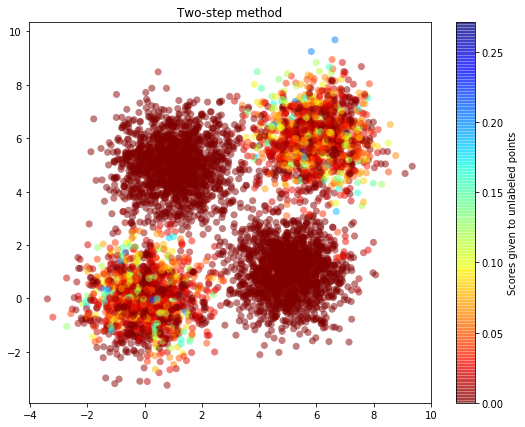

In [16]:
# Visualize this approach's final results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_stp, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

## Comparison of approaches

In [18]:
# For each data point, calculate the average score from the three approaches
results['output_all'] = results[[
    'output_std', 'output_bag', 'output_stp'
]].mean(axis = 1)

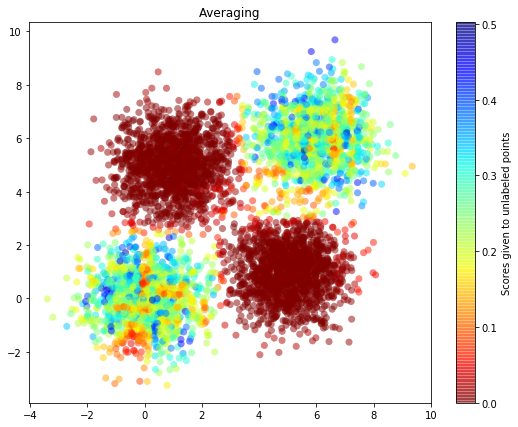

In [19]:
# Visualize average scores
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_all, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Averaging')
plt.show()

In [20]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bag', ascending = False
        ).head(t).truth.mean()
    )
    y_skb.append(
        results[results.label == 0].sort_values(
            'output_skb', ascending = False
        ).head(t).truth.mean()
    )
    y_stp.append(
        results[results.label == 0].sort_values(
            'output_stp', ascending = False
        ).head(t).truth.mean()
    )
    y_all.append(
        results[results.label == 0].sort_values(
            'output_all', ascending = False
        ).head(t).truth.mean()
    )

In [21]:
# Check the difference between PU bagging the 
# long way and using BaggingClassifierPU
[y_bag[i] - y_skb[i] for i in range(len(y_bag))]

[0.0,
 0.0,
 -0.010000000000000009,
 -0.007499999999999951,
 0.0,
 0.0,
 0.0,
 -0.0012499999999999734,
 -0.0011111111111110628,
 0.0010000000000000009,
 -0.0009090909090908594,
 -0.0008333333333333526,
 -0.0015384615384615996,
 -0.0014285714285714457,
 0.0,
 -0.0012499999999999734,
 -0.0017647058823528905,
 0.0,
 0.0,
 -0.0010000000000000009,
 0.0019047619047618536,
 0.00045454545454548523,
 0.00043478260869567187,
 0.0,
 -0.0008000000000000229,
 0.00038461538461531664]

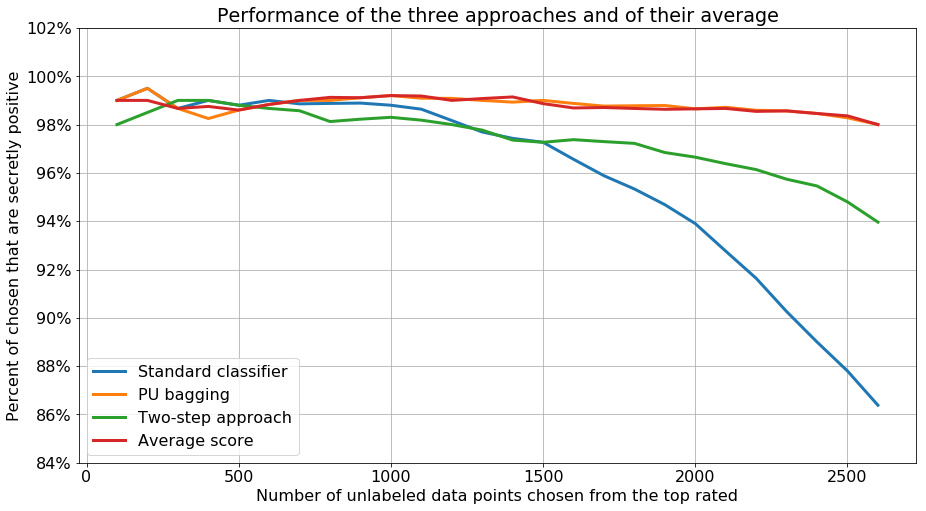

In [22]:
# Performance graphing
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_bag,
    ts, y_stp,
    ts, y_all,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier', 
    'PU bagging', 
    'Two-step approach', 
    'Average score'
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the three approaches and of their average')
plt.grid()
plt.show()

ref : https://github.com/roywright/pu_learning/blob/master/blobs.ipynb